In [26]:
# Import necessary modules and libraries

# Part 1

import datetime as dt
import pandas as pd
import ogr, gdal, osr, os
import geopandas as gpd
import matplotlib.pyplot as plt
import pyproj
import fiona
import itertools
import rasterio.mask
import numpy as np
import tkinter as tk
import gdal
import rasterio as rio
import warnings
import json
import time
import scipy.spatial
import re
import struct
import csv
import glob

from shapely.geometry import Point, Polygon
from pandas import DataFrame as df
from rasterio.fill import fillnodata
from rasterio.enums import Resampling
from rasterio.warp import calculate_default_transform, reproject
from rasterstats import point_query, zonal_stats
from tkinter import filedialog, messagebox
from earthpy import clip
from shapely.geometry import JOIN_STYLE, Point, Polygon
from geopandas import GeoSeries, GeoDataFrame
from math import ceil
from osgeo import gdal,ogr
from shapely.ops import unary_union, Polygon
from pathlib import Path
from pyproj import Proj


%matplotlib inline
warnings.filterwarnings('ignore')

root = tk.Tk()
root.withdraw()
root.attributes("-topmost", True)

''

# SECTION 1: Creating Agro Maps per crop

This notebook uses input data from <a href="https://www.mapspam.info/data/">MAP SAM</a>. The scope is to extract all crops available at the desired resolution (admin level 2) merge with spatial admin layer and produce output that can later on be used in the downscaling process.

**Original code:** [Alexandros Korkovelos](https://github.com/akorkovelos) <br />
**Conceptualization & Methodological review :** [Alexandros Korkovelos](https://github.com/akorkovelos) <br />
**Updates, Modifications:** [Alexandros Korkovelos](https://github.com/akorkovelos)<br />
**Funding:** The World Bank (contract number: 7190531), [KTH](https://www.kth.se/en/itm/inst/energiteknik/forskning/desa/welcome-to-the-unit-of-energy-systems-analysis-kth-desa-1.197296)

## Part 1. Creating csv files per crop

In [103]:
# Import agricultural data 

#path = r"C:\Oluchi\Benin\ben_spam_csv"
path = "C:\Oluchi\Somalia"
name_of_file = "som_spam.csv"
# Import csv as pandas dataframe
input_file= pd.read_csv(path + "\\" + name_of_file)

In [104]:
print ("The number of administrative areas (level 2) is {}, as shown below:".format(input_file.name_adm2.nunique()))
input_file.name_adm2.unique()

The number of administrative areas (level 2) is 48, as shown below:


array(['Ceel Afweyn', 'Borama', 'Baki', 'Sheikh', 'Gebiley', 'Owdweyne',
       'Burco', 'Hargeysa', 'Laas Caanood', 'Hobyo', 'Ceel Buur',
       'Xarardheere', 'Ceel Barde', 'Belet Weyne', 'Rab Dhuure', 'Xudur',
       'Ceel Dheer', 'Tayeeglow', 'Bulo Burto', 'Doolow', 'Luuq',
       'Waajid', 'Baydhaba', 'Adan Yabaal', 'Jalalaqsi', 'Garbahaarey',
       'Cadale', 'Jowhar', 'Qansax Dheere', 'Buur Hakaba', 'Wanla Weyn',
       'Baardheere', 'Balcad', 'Diinsoor', 'Afgooye', 'Qoryooley',
       'Banadir', 'Saakow', 'Kurtunwaarey', 'Marka', 'Sablaale',
       'Baraawe', "Bu'aale", 'Afmadow', 'Jilib', 'Jamaame', 'Kismaayo',
       'Badhaadhe'], dtype=object)

### Extracting crop data per admin 2 to unique datarames

#### Crop 1: Maize

In [105]:
input_file.columns

Index(['iso3', 'prod_level', 'alloc_key', 'cell5m', 'x', 'y', 'rec_type',
       'tech_type', 'unit', 'whea_a', 'rice_a', 'maiz_a', 'barl_a', 'pmil_a',
       'smil_a', 'sorg_a', 'ocer_a', 'pota_a', 'swpo_a', 'yams_a', 'cass_a',
       'orts_a', 'bean_a', 'chic_a', 'cowp_a', 'pige_a', 'lent_a', 'opul_a',
       'soyb_a', 'grou_a', 'cnut_a', 'oilp_a', 'sunf_a', 'rape_a', 'sesa_a',
       'ooil_a', 'sugc_a', 'sugb_a', 'cott_a', 'ofib_a', 'acof_a', 'rcof_a',
       'coco_a', 'teas_a', 'toba_a', 'bana_a', 'plnt_a', 'trof_a', 'temf_a',
       'vege_a', 'rest_a', 'total_a', 'cere_a', 'root_a', 'puls_a', 'oilc_a',
       'mill_a', 'coff_a', 'fruit_a', 'banpl_a', 'crea_date', 'year_data',
       'source', 'name_cntr', 'name_adm1', 'name_adm2'],
      dtype='object')

In [106]:
# Select crop and create subset dataframe
#maize crop is selected : maiz_A
df_maize = df(input_file, columns= ['iso3', 'prod_level', 'alloc_key','cell5m', 'x', 'y','maiz_a', 'name_cntr', 'name_adm1','name_adm2'])

In [107]:
# Calculate total harvested area
Maize_harv_area_ha_spam = df_maize['maiz_a'].sum()
print("\033[1m" + "Total harvested area for Maize under the selected parameters is:", Maize_harv_area_ha_spam, "ha")

# Other stats on the dataset
df_maize.describe()

Total harvested area for Maize under the selected parameters is: 100331.4 ha


,alloc_key,cell5m,x,y,maiz_a
count,1.390000e+03,1.390000e+03,1390.000000,1390.000000,1390.000000
mean,1.042088e+07,4.499027e+06,44.188129,3.223441,72.180863
std,2.730727e+05,1.179630e+05,1.526329,2.275671,167.811110
min,9.522722e+06,4.111041e+06,41.208333,-1.541667,0.000000
25%,1.029270e+07,4.443654e+06,43.208333,1.875000,0.000000
50%,1.044269e+07,4.508444e+06,43.958333,3.041667,6.400000
75%,1.058268e+07,4.568922e+06,45.125000,4.291667,39.300000
max,1.099266e+07,4.746019e+06,48.958333,10.708333,1481.000000


In [108]:
# Estimate share of harvested area per admin_2 level (this will be used later for projection)
df_maize["Admin_2_share"] = df_maize['maiz_a'] / Maize_harv_area_ha_spam

In [109]:
x= df_maize["Admin_2_share"].sum()
print(x)

1.0


#### Projection to 2018 values based on [FAOSTAT](http://www.fao.org/faostat/en/#data/QC)

This code uses most updated vales for harvested area aggragated at national level, and distributes the values to admin 2 level sistricts based on shares estimated in previous steps. This method has of course caveats however, is the best available alternative in the absence of higher granularity data.

In [110]:
# This is the value retrieved from the source
Maize_harv_area_ha_2018 = 92920

df_maize["Area_Harv_2018"] = df_maize["Admin_2_share"] * Maize_harv_area_ha_2018

In [111]:
df_maize

,iso3,prod_level,alloc_key,cell5m,x,y,maiz_a,name_cntr,name_adm1,name_adm2,Admin_2_share,Area_Harv_2018
0,SOM,SO13001,9522722,4111041,46.791667,10.708333,547.2,Somalia,Sanaag,Ceel Afweyn,0.005454,506.778775
1,SOM,SO13001,9532722,4115361,46.791667,10.625000,468.3,Somalia,Sanaag,Ceel Afweyn,0.004668,433.707055
2,SOM,SO13001,9532723,4115362,46.875000,10.625000,694.5,Somalia,Sanaag,Ceel Afweyn,0.006922,643.197842
3,SOM,SO01002,9592677,4141236,43.041667,10.125000,0.0,Somalia,Awdal,Borama,0.000000,0.000000
4,SOM,SO01002,9602677,4145556,43.041667,10.041667,4.7,Somalia,Awdal,Borama,0.000047,4.352815
...,...,...,...,...,...,...,...,...,...,...,...,...
1385,SOM,SO10002,10972661,4737380,41.708333,-1.375000,3.6,Somalia,Juba Hoose,Badhaadhe,0.000036,3.334071
1386,SOM,SO10002,10982659,4741698,41.541667,-1.458333,7.0,Somalia,Juba Hoose,Badhaadhe,0.000070,6.482916
1387,SOM,SO10002,10982660,4741699,41.625000,-1.458333,6.8,Somalia,Juba Hoose,Badhaadhe,0.000068,6.297689
1388,SOM,SO10002,10992659,4746018,41.541667,-1.541667,18.6,Somalia,Juba Hoose,Badhaadhe,0.000185,17.226033


#### Crop 2: Sorghum

In [112]:
# Select crop and create subset dataframe
#cassava crop is selected : cass_a
df_sorghum = df(input_file, columns= ['iso3', 'prod_level', 'alloc_key','cell5m', 'x', 'y','sorg_a', 'name_cntr', 'name_adm1','name_adm2'])

# Calculate total harvested area for the selected crop
Sorghum_harv_area_ha_spam = df_sorghum['sorg_a'].sum()
print("\033[1m" + "Total harvested area for Sorghum under the selected parameters is:",Sorghum_harv_area_ha_spam, "ha")

# Other stats on the dataset
df_sorghum.describe()

Total harvested area for Sorghum under the selected parameters is: 214812.30000000002 ha


,alloc_key,cell5m,x,y,sorg_a
count,1.390000e+03,1.390000e+03,1390.000000,1390.000000,1390.000000
mean,1.042088e+07,4.499027e+06,44.188129,3.223441,154.541223
std,2.730727e+05,1.179630e+05,1.526329,2.275671,325.466217
min,9.522722e+06,4.111041e+06,41.208333,-1.541667,0.000000
25%,1.029270e+07,4.443654e+06,43.208333,1.875000,5.000000
50%,1.044269e+07,4.508444e+06,43.958333,3.041667,24.200000
75%,1.058268e+07,4.568922e+06,45.125000,4.291667,163.350000
max,1.099266e+07,4.746019e+06,48.958333,10.708333,3510.400000


In [113]:
# Estimate share of harvested area per admin_2 level (this will be used later for projection)
df_sorghum["Admin_2_share"] = df_sorghum['sorg_a'] / Sorghum_harv_area_ha_spam

In [114]:
y= df_sorghum["Admin_2_share"].sum()
print(y)

1.0


#### Projection to 2018 values based on [FAOSTAT](http://www.fao.org/faostat/en/#data/QC)

This code uses most updated vales for harvested area aggragated at national level, and distributes the values to admin 2 level sistricts based on shares estimated in previous steps. This method has of course caveats however, is the best available alternative in the absence of higher granularity data.

In [84]:
# This is the value retrieved from the source
Sorghum_harv_area_ha_2018 = 234403

df_sorghum["Area_Harv_2018"] = df_sorghum["Admin_2_share"] * Sorghum_harv_area_ha_2018

In [85]:
df_sorghum

,iso3,prod_level,alloc_key,cell5m,x,y,sorg_a,name_cntr,name_adm1,name_adm2,Admin_2_share,Area_Harv_2018
0,SOM,SO13001,9522722,4111041,46.791667,10.708333,747.4,Somalia,Sanaag,Ceel Afweyn,0.003479,815.562248
1,SOM,SO13001,9532722,4115361,46.791667,10.625000,461.0,Somalia,Sanaag,Ceel Afweyn,0.002146,503.042810
2,SOM,SO13001,9532723,4115362,46.875000,10.625000,1011.6,Somalia,Sanaag,Ceel Afweyn,0.004709,1103.857064
3,SOM,SO01002,9592677,4141236,43.041667,10.125000,0.0,Somalia,Awdal,Borama,0.000000,0.000000
4,SOM,SO01002,9602677,4145556,43.041667,10.041667,0.0,Somalia,Awdal,Borama,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
1385,SOM,SO10002,10972661,4737380,41.708333,-1.375000,33.4,Somalia,Juba Hoose,Badhaadhe,0.000155,36.446052
1386,SOM,SO10002,10982659,4741698,41.541667,-1.458333,171.2,Somalia,Juba Hoose,Badhaadhe,0.000797,186.813295
1387,SOM,SO10002,10982660,4741699,41.625000,-1.458333,165.7,Somalia,Juba Hoose,Badhaadhe,0.000771,180.811700
1388,SOM,SO10002,10992659,4746018,41.541667,-1.541667,451.6,Somalia,Juba Hoose,Badhaadhe,0.002102,492.785538


### Exporting crop dataframes into separate csv

This part exports the csv files for the crops identified. These csv files can be used in a GIS environment (e.g. Qgis) and be merged with the admin 2 layer. In case you want to proceed and perform this here using geopandas, please proceed to the following steps.

In [86]:
## Define output path
#path = r"C:\Benin\agrodem_preprocessing\Downscaling\Output_Data\Crop_Maps_modified_SPAM\Somalia"

#df_maize.to_csv(os.path.join(path,"{c}.csv".format(c="Som_Maize_test")))
#df_sorghum.to_csv(os.path.join(path,"{c}.csv".format(c="Som_Sorghum_test")))

In [87]:
df_maize.head()

,iso3,prod_level,alloc_key,cell5m,x,y,maiz_a,name_cntr,name_adm1,name_adm2,Admin_2_share,Area_Harv_2018
0,SOM,SO13001,9522722,4111041,46.791667,10.708333,547.2,Somalia,Sanaag,Ceel Afweyn,0.005454,506.778775
1,SOM,SO13001,9532722,4115361,46.791667,10.625000,468.3,Somalia,Sanaag,Ceel Afweyn,0.004668,433.707055
2,SOM,SO13001,9532723,4115362,46.875000,10.625000,694.5,Somalia,Sanaag,Ceel Afweyn,0.006922,643.197842
3,SOM,SO01002,9592677,4141236,43.041667,10.125000,0.0,Somalia,Awdal,Borama,0.000000,0.000000
4,SOM,SO01002,9602677,4145556,43.041667,10.041667,4.7,Somalia,Awdal,Borama,0.000047,4.352815


## Part 2. Performing spatial join (merge) using geopandas

### Import admin 2 layer

In this case this is a shapefile, but other formats can be accepted here.

In [88]:
path = r"C:\Oluchi\Somalia\Admin_boundaries_3395"
name_shp = "gadm36_SOM_2_3395.shp"
admin_2_gdf = gpd.read_file(path + "\\" + name_shp)

In [89]:
admin_2_gdf.columns

Index(['GID_0', 'NAME_0', 'GID_1', 'NAME_1', 'NL_NAME_1', 'GID_2', 'NAME_2',
       'VARNAME_2', 'NL_NAME_2', 'TYPE_2', 'ENGTYPE_2', 'CC_2', 'HASC_2',
       '_mean', 'geometry'],
      dtype='object')

In [90]:
admin_2_gdf.head(3)

,GID_0,NAME_0,GID_1,NAME_1,NL_NAME_1,GID_2,NAME_2,VARNAME_2,NL_NAME_2,TYPE_2,ENGTYPE_2,CC_2,HASC_2,_mean,geometry
0,SOM,Somalia,SOM.1_1,Awdal,None,SOM.1.1_1,Baki,None,None,District,District,None,SO.AW.BA,256.933333,"POLYGON ((4913642.256 1144057.762, 4902510.476..."
1,SOM,Somalia,SOM.1_1,Awdal,None,SOM.1.2_1,Boorama,Boramo| Borama,None,District,District,None,SO.AW.BO,31.979999,"POLYGON ((4830152.638 1086776.879, 4821247.299..."
2,SOM,Somalia,SOM.1_1,Awdal,None,SOM.1.3_1,Lughaya,Lughaye,None,District,District,None,SO.AW.LU,NaN,"POLYGON ((4812341.536 1163172.109, 4801209.757..."


### Step1 : Renaming dfs

First, we need to rename the admin_2 column name in the previous dataframe in order to match with the "merging" column in the imported shapefile

In [91]:
admin_2_gdf.rename(columns={"NAME_2":"name_adm2"}, inplace=True)

### Step 2: Creating unique gdfs per crop

In [92]:
admin_2_maize_gdf = admin_2_gdf.merge(df_maize, on="name_adm2")
admin_2_sorghum_gdf = admin_2_gdf.merge(df_sorghum, on="name_adm2")
#admin_2_cassava_gdf = admin_2_gdf.merge(df_cassava, on="name_adm2")
#admin_2_yams_gdf = admin_2_gdf.merge(df_yams, on="name_adm2")
#admin_2_cotton_gdf = admin_2_gdf.merge(df_cotton, on="name_adm2")

### Step 3: Cross-checking estimated

Calculating total area per district and cross-checking that projected harvested ara (as per method above) does not surpasses physical limits. Areas in ha.

#### Crop 1: Maize

harv_area_2018_ha

In [93]:
admin_2_maize_gdf["tot_dist_area_ha"] = admin_2_maize_gdf['geometry'].to_crs({'init': 'epsg:3395'})\
                .map(lambda p: p.area / 10**4)
admin_2_maize_gdf["Test"] = admin_2_maize_gdf["tot_dist_area_ha"] > admin_2_maize_gdf["Area_Harv_2018"]
admin_2_maize_gdf["Test"].unique

<bound method Series.unique of 0      True
1      True
2      True
3      True
4      True
       ... 
800    True
801    True
802    True
803    True
804    True
Name: Test, Length: 805, dtype: bool>

In [94]:
# Adding new column for the share of harvested area over the total area per district
admin_2_maize_gdf["harv_share_of_tot"] = admin_2_maize_gdf["Area_Harv_2018"] / admin_2_maize_gdf["tot_dist_area_ha"]

#### Crop 2:  Sorghum

In [95]:
admin_2_sorghum_gdf["tot_dist_area_ha"] = admin_2_sorghum_gdf['geometry'].to_crs({'init': 'epsg:3395'})\
                .map(lambda p: p.area / 10**4)
admin_2_sorghum_gdf["Test"] =admin_2_sorghum_gdf["tot_dist_area_ha"] > admin_2_sorghum_gdf["Area_Harv_2018"]
admin_2_sorghum_gdf["Test"].unique

<bound method Series.unique of 0      True
1      True
2      True
3      True
4      True
       ... 
800    True
801    True
802    True
803    True
804    True
Name: Test, Length: 805, dtype: bool>

In [96]:
# Adding new column for the share of harvested area over the total area per district
admin_2_sorghum_gdf["harv_share_of_tot"] = admin_2_sorghum_gdf["Area_Harv_2018"] / admin_2_sorghum_gdf["tot_dist_area_ha"]

### Step 4: Cleaning the gdfs

In [97]:
admin_2_maize_gdf.columns

Index(['GID_0', 'NAME_0', 'GID_1', 'NAME_1', 'NL_NAME_1', 'GID_2', 'name_adm2',
       'VARNAME_2', 'NL_NAME_2', 'TYPE_2', 'ENGTYPE_2', 'CC_2', 'HASC_2',
       '_mean', 'geometry', 'iso3', 'prod_level', 'alloc_key', 'cell5m', 'x',
       'y', 'maiz_a', 'name_cntr', 'name_adm1', 'Admin_2_share',
       'Area_Harv_2018', 'tot_dist_area_ha', 'Test', 'harv_share_of_tot'],
      dtype='object')

In [98]:
# Maize
admin_2_maize_gdf.rename(columns={"NAME_0":"country",
                                  "GID_0":"country_code",
                                  "name_adm2":"admin2",
                                  "maiz_a":"harea_spam_ha",
                                  "Admin_2_share": "shareofsum",
                                  "Area_Harv_2018":"harv_area_ha",
                                  "tot_dist_area_ha":"district_area_ha",
                                  "harv_share_of_tot":"shareofdistrict"}, inplace=True)

admin_2_maize_gdf = admin_2_maize_gdf.drop(['GID_1','VARNAME_2','TYPE_2' ,'NAME_1', 'NL_NAME_1', 'GID_2','NL_NAME_2', 'ENGTYPE_2','CC_2', 'HASC_2','iso3', 'prod_level','name_adm1','Test'], axis=1)

# Sorghum
admin_2_sorghum_gdf.rename(columns={"NAME_0":"country",
                                  "GID_0":"country_code",
                                  "name_adm2":"admin2",
                                  "sorg_a":"harea_spam_ha",
                                  "Admin_2_share": "shareofsum",
                                  "Area_Harv_2018":"harv_area_ha",
                                  "tot_dist_area_ha":"district_area_ha",
                                  "harv_share_of_tot":"shareofdistrict"}, inplace=True)

admin_2_sorghum_gdf = admin_2_sorghum_gdf.drop(['GID_1','VARNAME_2','TYPE_2' ,'NAME_1', 'NL_NAME_1', 'GID_2','NL_NAME_2', 'ENGTYPE_2','CC_2', 'HASC_2','iso3', 'prod_level','name_adm1','Test'], axis=1)

### Quick visualization of results

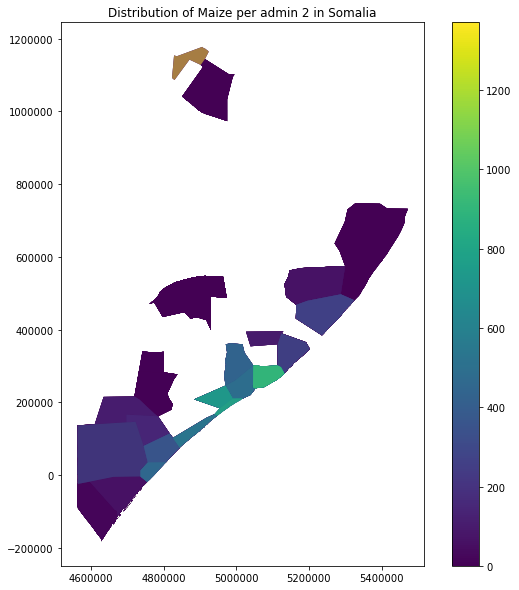

In [99]:
#Maize

# Create the axis first
fig, ax = plt.subplots(figsize=(10, 10))

# Plot all crops
admin_2_maize_gdf.sort_values('harv_area_ha', ascending=True).plot(
    ax=ax, column='harv_area_ha', legend=True, alpha=0.5)

# Make figure aspect ratio ensure that 10x10 km square appears square
ax.set_aspect('equal', 'box')
txt = ax.set_title('Distribution of {} per admin 2 in Somalia'.format("Maize"))

# Save plot as figure 
plt.savefig('Maize_Harv_Area_2018_Somlaia.png', bbox_inches='tight')

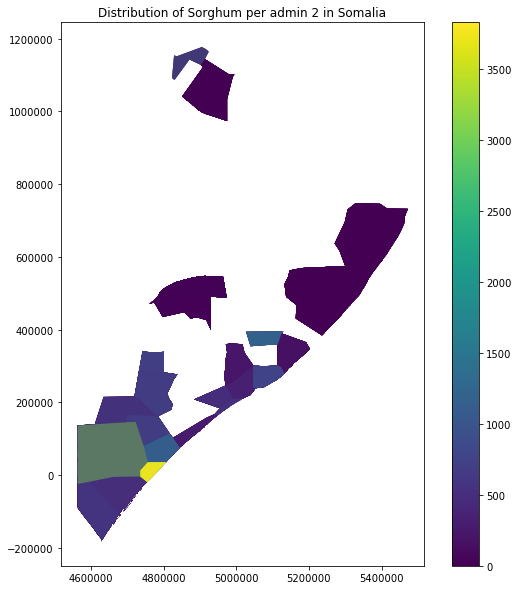

In [100]:
#Sorghum

# Create the axis first
fig, ax = plt.subplots(figsize=(10, 10))

# Plot all crops
admin_2_sorghum_gdf.sort_values('harv_area_ha', ascending=True).plot(
    ax=ax, column='harv_area_ha', legend=True, alpha=0.5)

# Make figure aspect ratio ensure that 10x10 km square appears square
ax.set_aspect('equal', 'box')
txt = ax.set_title('Distribution of {} per admin 2 in Somalia'.format("Sorghum"))

# Save plot as figure 
plt.savefig('Sorghum_Harv_Area_2018_Somalia.png', bbox_inches='tight')

### Exporting gdfs to shapefiles (shp)

In [101]:
# Define output path
#path = r"N:\Agrodem\Downscaling\Output_Data\Crop_Maps"
path = r"C:\AgriDem\agrodem_preprocessing\Downscaling\Output_Data\Crop_Maps\Somalia"

#Maize
admin_2_maize_gdf.to_file(os.path.join(path,"{c}.shp".format(c="Som_Maize_2018_admin2")))

#Cassava
admin_2_sorghum_gdf.to_file(os.path.join(path,"{c}.shp".format(c="Som_Sorghum_2018_admin2")))

### Exporting gdfs to shapefiles (csv)

In [135]:
# Define output path
#path = r"N:\Agrodem\Downscaling\Output_Data\Crop_Maps"
#path = r"C:\Benin\agrodem_preprocessing\Downscaling\Output_Data\Crop_Maps"


#Maize
#admin_2_maize_gdf.to_csv(os.path.join(path,"{c}.csv".format(c="Ben_Maize_2018_admin2")))

#Cassava
#admin_2_cassava_gdf.to_csv(os.path.join(path,"{c}.csv".format(c="Ben_Cassava_2018_admin2")))

# SECTION 2: Creating  a grid-base-map of desired output spatial resolution


# Selecting Datasets
Select the workspace, this is the folder that will be used for the outputs. 
NOTE Select an empty folder as all the files will be deleted from the workspace 

You will also have to select the two datasets used in the analysis. These are:
    
1) Administrative boundaries.

2) Agro Maps

In [43]:
#Output folder - Ideally, should be found in Output_data\FAO_AgroMap_Crops
messagebox.showinfo('AGRODEM Creating base grid', 'Output folder')
workspace = filedialog.askdirectory()

#Administrative boundaries - Ideally, should be found in Input_Data/admin_data
messagebox.showinfo('AGRODEM Creating base grid', 'Select the administrative boundaries')
filename_admin = (filedialog.askopenfilename(filetypes = (("shapefile","*.shp"),("all files","*.*"))))
admin=gpd.read_file(filename_admin)

#The output file of step 1 -  "Prepping_Agro_Maps.ipynb" is what should be used here. It should easily be found in Outputdata/Crop_Maps
messagebox.showinfo('AGRODEM Creating base grid', 'Select the agro map. This should be the output of the Section 1: Creating Agro Maps Section')
filename_agro = (filedialog.askopenfilename(filetypes = (("shapefile","*.shp"),("all files","*.*"))))
agro=gpd.read_file(filename_agro)

In [ ]:
#The output file of step 1 -  "Prepping_Agro_Maps.ipynb" is what should be used here. It should easily be found in Outputdata/Crop_Maps

agro = gpd.read_file()

In [44]:
agro.head()

,country_co,country,admin2,VARNAME_2,TYPE_2,Production,iso3,prod_level,alloc_key,cell5m,...,y,maiz_a,name_cntr,name_adm1,shareofsum,harv_area_,district_a,Test,shareofdis,geometry
0,BEN,Benin,Banikoara,None,Commune,50419.0,BEN,BN01001,9412189,4062988,...,11.625000,568.4,Benin,Alibori,0.000523,605.834085,437677.965476,1,0.001384,"POLYGON ((483285.095 1262585.664, 483460.594 1..."
1,BEN,Benin,Banikoara,None,Commune,50419.0,BEN,BN01001,9412190,4062989,...,11.625000,801.5,Benin,Alibori,0.000738,854.285747,437677.965476,1,0.001952,"POLYGON ((483285.095 1262585.664, 483460.594 1..."
2,BEN,Benin,Banikoara,None,Commune,50419.0,BEN,BN01001,9412191,4062990,...,11.625000,581.5,Benin,Alibori,0.000535,619.796834,437677.965476,1,0.001416,"POLYGON ((483285.095 1262585.664, 483460.594 1..."
3,BEN,Benin,Banikoara,None,Commune,50419.0,BEN,BN01001,9422188,4067307,...,11.541667,0.0,Benin,Alibori,0.000000,0.000000,437677.965476,1,0.000000,"POLYGON ((483285.095 1262585.664, 483460.594 1..."
4,BEN,Benin,Banikoara,None,Commune,50419.0,BEN,BN01001,9422189,4067308,...,11.541667,605.3,Benin,Alibori,0.000557,645.164271,437677.965476,1,0.001474,"POLYGON ((483285.095 1262585.664, 483460.594 1..."


# Select the target coordinate system


Find the appropriate target crs from:  https://epsg.io/

In [45]:
crs = 'EPSG:3395'

# Ensuring vectors are in the same coordinate system

In [46]:
# reprojecing to target coordinate system written above
def target_crs(vectors,crs,workspace):   
    vectors = vectors.to_crs(crs) 
    vectors.to_file(workspace, driver='ESRI Shapefile')  
    return vectors

agro_pr = agro.to_crs(crs)
admin_pr = admin.to_crs(crs)

# Fix geometries

In [47]:
def fixgeometries(polygon):
    #creates a valid representation of a given invalid geometry without losing any of the input vertices. 
    fix = polygon.buffer(0.001)
    return fix

# Preparing agro maps

In [48]:
#clip agro map to place of interest
clipped_agro = gpd.clip(agro_pr,admin_pr)


#Determining yield 
#clipped_agro['yield'] =  clipped_agro['Production_kg']  / clipped_agro['harv_area_']   

#Calculating the area of each unit [ha]
clipped_agro['area'] =  (clipped_agro['geometry'].area)/10000

#Calculating the perimeter of each unit [km]
clipped_agro["perimeter"] = (clipped_agro["geometry"].length)/10000

# Creating base point layer

In [ ]:
def make_grid(gdf, height, cut=True):
    """
    Return a grid, based on the shape of *gdf* and on a *height* value (in
    units of *gdf*). If cut=False, the grid will not be intersected with *gdf*
    (i.e it makes a grid on the bounding-box of *gdf*).
    Parameters
    ----------
    gdf: GeoDataFrame
        The collection of polygons to be covered by the grid.
    height: Integer
        The dimension (will be used as height and width) of the ceils to create,
        in units of *gdf*.
    cut: Boolean, default True
        Cut the grid to fit the shape of *gdf* (ceil partially covering it will
        be truncated). If False, the returned grid will fit the bounding box
        of *gdf*.
    Returns
    -------
    grid: GeoDataFrame
        A collection of polygons.
    """
   
    xmin, ymin = [i.min() for i in gdf.bounds.T.values[:2]]
    xmax, ymax = [i.max() for i in gdf.bounds.T.values[2:]]
    rows = int(ceil((ymax-ymin) / height))
    cols = int(ceil((xmax-xmin) / height))

    x_left_origin = xmin
    x_right_origin = xmin + height
    y_top_origin = ymax
    y_bottom_origin = ymax - height

    res_geoms = []
    for countcols in range(cols):
        y_top = y_top_origin
        y_bottom = y_bottom_origin
        for countrows in range(rows):
            res_geoms.append((
                (x_left_origin, y_top), (x_right_origin, y_top),
                (x_right_origin, y_bottom), (x_left_origin, y_bottom)
                ))
            y_top = y_top - height
            y_bottom = y_bottom - height
        x_left_origin = x_left_origin + height
        x_right_origin = x_right_origin + height
    if cut:
        if all(gdf.eval(
            "geometry.type =='Polygon' or geometry.type =='MultiPolygon'")):
            res = GeoDataFrame(
                geometry=pd.Series(res_geoms).apply(lambda x: Polygon(x)),
                crs=gdf.crs
                ).intersection(unary_union(gdf.geometry))
        else:
            res = GeoDataFrame(
                geometry=pd.Series(res_geoms).apply(lambda x: Polygon(x)),
                crs=gdf.crs
                ).intersection(unary_union(gdf.geometry).convex_hull)
        res = res[res.geometry.type == 'Polygon']
        res.index = [i for i in range(len(res))]
        return GeoDataFrame(geometry=res)

    else:
        return GeoDataFrame(
            index=[i for i in range(len(res_geoms))],
            geometry=pd.Series(res_geoms).apply(lambda x: Polygon(x)),
            crs=gdf.crs
            )

In [ ]:
clipped_agro.columns

In [ ]:
# Fill in the desired output resolution in the "height" variable, the higher the resolution the longer it takes to run. 
# For 250m , height = 250 ; for 1km, height =1000; for 10km, height = 10000, etc.

height = 1000

grid=make_grid(clipped_agro,height, cut=False)

#clip point layer and join based on location 
clipped_grid=gpd.overlay(grid,clipped_agro, how='intersection', make_valid=True, keep_geom_type=True)

#reproject layer to target coordinate system
clipped_grid_pr= clipped_grid.to_crs(crs)

In [ ]:
#adding point coordinates to layer
def keep_first(geo):
   if geo.geom_type == 'Polygon':
       return geo
   elif geo.geom_type == 'MultiPolygon':
       return geo[0]

clipped_grid_pr.geometry = clipped_grid_pr.geometry.apply(lambda _geo: keep_first(_geo))

clipped_grid_pr['geometry']=clipped_grid_pr.centroid

In [ ]:
def conditioning(clipped_grid_pr, workspace):
    agro_update = clipped_grid_pr.to_crs({ 'init': 'epsg:3395'}) 

    
    
    agro_update = agro_update.rename(columns={"id": "id", "admin2" : "state", "country_co":"c_code",
                                              "country":"country","crop":"crop","year":"year",
                                              "harv_area_":"harv_area_ha", "yield":"yield",
                                              "Production_kg":"Production_kg", "area":"statearea_ha",
                                              "perimeter":"perimeter_km"})
        
    agro_update["X_deg"] = agro_update.geometry.centroid.x
    
    agro_update["Y_deg"] = agro_update.geometry.centroid.y
    
    agro_update.to_file(workspace + r"\output.shp", driver='ESRI Shapefile')
    agro_update.to_file(workspace + r"\output.csv", driver='CSV')
    print(datetime.datetime.now())
    return agro_update

In [ ]:
agro_final = conditioning(clipped_grid, workspace)

# Section3: Fine-scale Land Allocation Tool Prepping
This code prepares the final input file to the FLAT model

In [153]:
#Import Data
path = r"C:\AgriDem\agrodem_preprocessing\Downscaling\Output_Data\Creating_data_qgis_SPAM\Somalia"
name_of_file = "sorghum_basegrid_1km_SOM.csv"

In [154]:
# Import csv as pandas dataframe
df = pd.read_csv(path + "\\" + name_of_file)
df.head(3)

,id,state,c_code,country,crop,harv_ar_ha,yield,prod_tonne,statear_ha,permtr_km,lon,lat
0,183941,Baki,SOM,Somalia,NaN,1188.752358,NaN,NaN,357780.289751,325.466678,44.077679,10.588455
1,185101,Baki,SOM,Somalia,NaN,1188.752358,NaN,NaN,357780.289751,325.466678,44.059713,10.579567
2,185102,Baki,SOM,Somalia,NaN,1188.752358,NaN,NaN,357780.289751,325.466678,44.068696,10.579567


In [155]:
df.columns

Index(['id', 'state', 'c_code', 'country', 'crop', 'harv_ar_ha', 'yield',
       'prod_tonne', 'statear_ha', 'permtr_km', 'lon', 'lat'],
      dtype='object')

In [156]:
# Add geometry and convert to spatial dataframe in source CRS
df['geometry'] = list(zip(df['lon'], df['lat']))
df['geometry'] = df['geometry'].apply(Point)
df = gpd.GeoDataFrame(df, geometry='geometry', crs={'init': 'epsg:4326'})

# Reproject data in to Ordnance Survey GB coordinates
df = df.to_crs({'init': 'epsg:3395'})

In [157]:
df.head()

,id,state,c_code,country,crop,harv_ar_ha,yield,prod_tonne,statear_ha,permtr_km,lon,lat,geometry
0,183941,Baki,SOM,Somalia,NaN,1188.752358,NaN,NaN,357780.289751,325.466678,44.077679,10.588455,POINT (4906704.794 1177622.033)
1,185101,Baki,SOM,Somalia,NaN,1188.752358,NaN,NaN,357780.289751,325.466678,44.059713,10.579567,POINT (4904704.794 1176622.033)
2,185102,Baki,SOM,Somalia,NaN,1188.752358,NaN,NaN,357780.289751,325.466678,44.068696,10.579567,POINT (4905704.794 1176622.033)
3,185103,Baki,SOM,Somalia,NaN,1188.752358,NaN,NaN,357780.289751,325.466678,44.077679,10.579567,POINT (4906704.794 1176622.033)
4,186260,Baki,SOM,Somalia,NaN,1188.752358,NaN,NaN,357780.289751,325.466678,44.032763,10.570679,POINT (4901704.794 1175622.033)


In [158]:
#Function to change the order of columns in the dataframe 
def change_column_order(df, col_name, index):
    cols = df.columns.tolist()
    cols.remove(col_name)
    cols.insert(index, col_name)
    return df[cols]

In [159]:
# Allocate order in dataframe columns
df = change_column_order(df, 'id', 1)
df = change_column_order(df, 'lon', 2)
df = change_column_order(df, 'lat', 3)
df = change_column_order(df, 'country', 4)
df = change_column_order(df, 'c_code', 5)
df = change_column_order(df, 'statear_ha', 6)
df = change_column_order(df, 'harv_ar_ha', 7)

In [160]:
df.head()

,state,id,lon,lat,country,c_code,statear_ha,harv_ar_ha,crop,yield,prod_tonne,permtr_km,geometry
0,Baki,183941,44.077679,10.588455,Somalia,SOM,357780.289751,1188.752358,NaN,NaN,NaN,325.466678,POINT (4906704.794 1177622.033)
1,Baki,185101,44.059713,10.579567,Somalia,SOM,357780.289751,1188.752358,NaN,NaN,NaN,325.466678,POINT (4904704.794 1176622.033)
2,Baki,185102,44.068696,10.579567,Somalia,SOM,357780.289751,1188.752358,NaN,NaN,NaN,325.466678,POINT (4905704.794 1176622.033)
3,Baki,185103,44.077679,10.579567,Somalia,SOM,357780.289751,1188.752358,NaN,NaN,NaN,325.466678,POINT (4906704.794 1176622.033)
4,Baki,186260,44.032763,10.570679,Somalia,SOM,357780.289751,1188.752358,NaN,NaN,NaN,325.466678,POINT (4901704.794 1175622.033)


In [161]:
# Define output path
# Overwriting the csv file
#path = r"N:\Agrodem\Downscaling\Output_Data\FAO_AgroMap_Crops"
path = r"C:\AgriDem\agrodem_preprocessing\Downscaling\Output_Data\Crop_Maps_modified_SPAM\Somalia"
shpname = "Som_Sorghum_Harv_2018_admin2_1km.csv"

#MAIZE
df.to_csv(os.path.join(path,"{c}".format(c=shpname)), index=False)
df.to_file('Som_Sorghum_Harv_2018_admin2_1km.shp',driver = 'ESRI Shapefile')
# Define output path
#path = r"N:\Agrodem\Downscaling\Output_Data\Crop_Maps"
#path = r"C:\Benin\agrodem_preprocessing\Downscaling\Output_Data\Crop_Maps"

In [163]:
y = gpd.read_file(r'C:\Github\agrodem_new\agrodem_preprocessing\Downscaling\Downscaling_prepping_SPAMDATA\Som_Sorghum_Harv_2018_admin2_1km.shp')

In [164]:
y.head()

,state,id,lon,lat,country,c_code,statear_ha,harv_ar_ha,crop,yield,prod_tonne,permtr_km,geometry
0,Baki,183941,44.077679,10.588455,Somalia,SOM,357780.289751,1188.752358,None,None,None,325.466678,POINT (4906704.794 1177622.033)
1,Baki,185101,44.059713,10.579567,Somalia,SOM,357780.289751,1188.752358,None,None,None,325.466678,POINT (4904704.794 1176622.033)
2,Baki,185102,44.068696,10.579567,Somalia,SOM,357780.289751,1188.752358,None,None,None,325.466678,POINT (4905704.794 1176622.033)
3,Baki,185103,44.077679,10.579567,Somalia,SOM,357780.289751,1188.752358,None,None,None,325.466678,POINT (4906704.794 1176622.033)
4,Baki,186260,44.032763,10.570679,Somalia,SOM,357780.289751,1188.752358,None,None,None,325.466678,POINT (4901704.794 1175622.033)


In [165]:
y.describe()

,id,lon,lat,statear_ha,harv_ar_ha,permtr_km
count,6.223378e+06,6.223378e+06,6.223378e+06,6.223378e+06,6.223378e+06,6.223378e+06
mean,1.148106e+06,4.433135e+01,3.141074e+00,1.156474e+06,1.156441e+02,4.660059e+02
std,3.330700e+05,2.196565e+00,2.585453e+00,7.734670e+05,3.110529e+02,1.386299e+02
min,1.839410e+05,4.099646e+01,-1.640100e+00,9.315636e+04,0.000000e+00,2.264315e+02
25%,9.476510e+05,4.256851e+01,9.461262e-01,5.525609e+05,0.000000e+00,3.635097e+02
50%,1.128834e+06,4.398785e+01,3.295687e+00,9.698692e+05,2.422462e+01,4.683142e+02
75%,1.430462e+06,4.637737e+01,4.702986e+00,1.328653e+06,9.809880e+01,5.325772e+02
max,1.762822e+06,4.915316e+01,1.058845e+01,2.717781e+06,3.830546e+03,6.947285e+02


## Extracting raster input to csv 

In [166]:
raster_path = r"C:\Oluchi\Downscaling\Input_Data\raster_reprojected"
raster_files =[]
csvoutpath = r"C:\Oluchi\Downscaling\Output_Data\FLAT_Input\Somalia\1km_Sorghum"

print ("Reading independent variables...")

for i in os.listdir(raster_path):
    if i.endswith('.tif'):
        raster_files.append(i)  

#shp_filename = r"N:\Agrodem\Downscaling\Output_Data\FAO_AgroMap_Crops\shapefiles\Moz_Rice_Harv_2000_admin2_1km.shp"
shp_filename = r'C:\Github\agrodem_new\agrodem_preprocessing\Downscaling\Downscaling_prepping_SPAMDATA\Som_Sorghum_Harv_2018_admin2_1km.shp'
print ("Extracting raster values to points...")

for i in raster_files:
    print("Extracting " + i + " values...")
    src_filename = raster_path + "\\" + i 
    li_values = list()

    src_ds=gdal.Open(src_filename) 
    gt=src_ds.GetGeoTransform()
    rb=src_ds.GetRasterBand(1)
    ds=ogr.Open(shp_filename)    
    lyr=ds.GetLayer()
    
    
    for feat in lyr:
        geom = feat.GetGeometryRef()
        feat_id = feat.GetField('id')
        mx,my=geom.GetX(), geom.GetY()  #coord in map units

        #Convert from map to pixel coordinates.
        #Only works for geotransforms with no rotation.
        px = int((mx - gt[0]) / gt[1]) #x pixel
        py = int((my - gt[3]) / gt[5]) #y pixel

        intval=rb.ReadAsArray(px,py,1,1)
        li_values.append([feat_id, intval[0]])
        
    print ("Writing " + i + " values to csv...")
    
    with open(csvoutpath + "\\" + i.split('.')[0] + '.csv', 'w') as csvfile:
        wr = csv.writer(csvfile)
        wr.writerows(li_values)

Reading independent variables...
Extracting raster values to points...
Extracting BDRICM.tif values...
Writing BDRICM.tif values to csv...
Extracting BLD.tif values...
Writing BLD.tif values to csv...
Extracting CLYPPT.tif values...
Writing CLYPPT.tif values to csv...
Extracting DRAINFAO.tif values...
Writing DRAINFAO.tif values to csv...
Extracting GFSAD-landcover.tif values...
Writing GFSAD-landcover.tif values to csv...
Extracting landcover.tif values...
Writing landcover.tif values to csv...
Extracting MODIS-Band2.tif values...
Writing MODIS-Band2.tif values to csv...
Extracting modis-evi.tif values...
Writing modis-evi.tif values to csv...
Extracting modis-ndvi.tif values...
Writing modis-ndvi.tif values to csv...
Extracting ORCDRC.tif values...
Writing ORCDRC.tif values to csv...
Extracting PHIHOX.tif values...
Writing PHIHOX.tif values to csv...
Extracting prec.tif values...
Writing prec.tif values to csv...
Extracting srad.tif values...
Writing srad.tif values to csv...
Extract

## Merge csv files with crop

In [130]:
#Import data 

path = r"C:\AgriDem\agrodem_preprocessing\Downscaling\Output_Data\Crop_Maps_modified_SPAM\Somalia"

name_of_file= "Som_Sorghum_Harv_2018_admin2_1km.csv"

flat_input = pd.read_csv(path + "\\" + name_of_file)

In [131]:
csvoutpath = r"C:\Oluchi\Downscaling\Output_Data\FLAT_Input\Somalia\1km_Sorghum"
csv_files = []

print ("Reading csv files...")

for i in os.listdir(csvoutpath):
    if i.endswith('.csv'):
        csv_files.append(i)  

for i in csv_files:
    print('Reading...'+ i)    
    df_csv = pd.read_csv(csvoutpath + "//" + i, index_col=None, header=None)
    df_csv.iloc[:,1] = df_csv.iloc[:,1].astype(str)
    df_csv.iloc[:,1] = df_csv.iloc[:,1].str.replace('[','')
    df_csv.iloc[:,1] = df_csv.iloc[:,1].str.replace(']','')
    columnName = i.split('.')[0]
    print("Merging..." + columnName)
    flat_input[columnName] = df_csv.iloc[:,1]

Reading csv files...
Reading...BDRICM.csv
Merging...BDRICM
Reading...BLD.csv
Merging...BLD
Reading...CLYPPT.csv
Merging...CLYPPT
Reading...DRAINFAO.csv
Merging...DRAINFAO
Reading...GFSAD-landcover.csv
Merging...GFSAD-landcover
Reading...landcover.csv
Merging...landcover
Reading...MODIS-Band2.csv
Merging...MODIS-Band2
Reading...modis-evi.csv
Merging...modis-evi
Reading...modis-ndvi.csv
Merging...modis-ndvi
Reading...ORCDRC.csv
Merging...ORCDRC
Reading...PHIHOX.csv
Merging...PHIHOX
Reading...prec.csv
Merging...prec
Reading...srad.csv
Merging...srad
Reading...SRTM-elevation.csv
Merging...SRTM-elevation
Reading...tavg.csv
Merging...tavg
Reading...TEXMHT.csv
Merging...TEXMHT
Reading...wind.csv
Merging...wind


## Cleaning and normalizing dataframe

In [132]:
flat_input.head(10)

,state,id,lon,lat,country,c_code,statear_ha,harv_ar_ha,permtr_km,geometry,...,modis-evi,modis-ndvi,ORCDRC,PHIHOX,prec,srad,SRTM-elevation,tavg,TEXMHT,wind
0,Baki,183941,44.077679,10.588455,Somalia,SOM,357780.2898,1371.599719,325.466678,POINT (4906704.793874511 1177622.0335944),...,700.,1560.,0.,0.,0.,0.,9,-inf,0.,0.
1,Baki,185101,44.059713,10.579567,Somalia,SOM,357780.2898,1371.599719,325.466678,POINT (4904704.794507073 1176622.032852514),...,806.,948.,4.,68.,7.6666665,22353.666,19,29.949999,9.,4.3
2,Baki,185102,44.068696,10.579567,Somalia,SOM,357780.2898,1371.599719,325.466678,POINT (4905704.794190792 1176622.032852514),...,733.,934.,5.,72.,7.,22629.75,13,29.783335,9.,4.4
3,Baki,185103,44.077679,10.579567,Somalia,SOM,357780.2898,1371.599719,325.466678,POINT (4906704.793874511 1176622.032852514),...,940.,1472.,13.,69.,0.,0.,10,-inf,6.,0.
4,Baki,186260,44.032763,10.570679,Somalia,SOM,357780.2898,1371.599719,325.466678,POINT (4901704.794342719 1175622.033331025),...,854.,1037.,4.,76.,8.916667,21649.916,33,30.099998,9.,4.2
5,Baki,186261,44.041747,10.570679,Somalia,SOM,357780.2898,1371.599719,325.466678,POINT (4902704.794026438 1175622.033331025),...,641.,801.,4.,76.,8.75,21800.,31,30.033333,9.,4.3
6,Baki,186262,44.050730,10.570679,Somalia,SOM,357780.2898,1371.599719,325.466678,POINT (4903704.793710158 1175622.033331025),...,675.,867.,0.,0.,8.75,21800.,26,30.033333,0.,4.3
7,Baki,186263,44.059713,10.570679,Somalia,SOM,357780.2898,1371.599719,325.466678,POINT (4904704.794507073 1175622.033331025),...,766.,900.,4.,74.,8.75,21823.166,20,29.966665,9.,4.3
8,Baki,186264,44.068696,10.570679,Somalia,SOM,357780.2898,1371.599719,325.466678,POINT (4905704.794190792 1175622.033331025),...,817.,947.,4.,70.,7.9166665,22206.584,16,29.833336,9.,4.4
9,Baki,186265,44.077679,10.570679,Somalia,SOM,357780.2898,1371.599719,325.466678,POINT (4906704.793874511 1175622.033331025),...,1229.,1708.,13.,70.,7.4166665,22456.25,11,29.741669,6.,4.4


In [133]:
#Show columns
flat_input.columns

Index(['state', 'id', 'lon', 'lat', 'country', 'c_code', 'statear_ha',
       'harv_ar_ha', 'permtr_km', 'geometry', 'BDRICM', 'BLD', 'CLYPPT',
       'DRAINFAO', 'GFSAD-landcover', 'landcover', 'MODIS-Band2', 'modis-evi',
       'modis-ndvi', 'ORCDRC', 'PHIHOX', 'prec', 'srad', 'SRTM-elevation',
       'tavg', 'TEXMHT', 'wind'],
      dtype='object')

In [134]:
#Delete geometry column
flat_input = flat_input.drop(["geometry"], axis=1)

#### Convert values in newly added columns into float 

In [135]:
flat_input["harv_ar_ha"] = flat_input["harv_ar_ha"].astype(float)
flat_input["BDRICM"] = flat_input["BDRICM"].astype(float)
flat_input["BLD"] = flat_input["BLD"].astype(float)
flat_input["CLYPPT"] = flat_input["CLYPPT"].astype(float)
flat_input["DRAINFAO"] = flat_input["DRAINFAO"].astype(float)
flat_input["GFSAD-landcover"] = flat_input["GFSAD-landcover"].astype(float)
flat_input["landcover"] = flat_input["landcover"].astype(float)
flat_input["MODIS-Band2"] = flat_input["MODIS-Band2"].astype(float)
flat_input["modis-evi"] = flat_input["modis-evi"].astype(float)
flat_input["modis-ndvi"] = flat_input["modis-ndvi"].astype(float)
flat_input["ORCDRC"] = flat_input["ORCDRC"].astype(float)
flat_input["PHIHOX"] = flat_input["PHIHOX"].astype(float)
flat_input["prec"] = flat_input["prec"].astype(float)
flat_input["srad"] = flat_input["srad"].astype(float)
flat_input["SRTM-elevation"] = flat_input["SRTM-elevation"].astype(float)
flat_input["tavg"] = flat_input["tavg"].astype(float)
flat_input["TEXMHT"] = flat_input["TEXMHT"].astype(float)
flat_input["wind"] = flat_input["wind"].astype(float)

In [136]:
flat_input.dtypes

state               object
id                   int64
lon                float64
lat                float64
country             object
c_code              object
statear_ha         float64
harv_ar_ha         float64
permtr_km          float64
BDRICM             float64
BLD                float64
CLYPPT             float64
DRAINFAO           float64
GFSAD-landcover    float64
landcover          float64
MODIS-Band2        float64
modis-evi          float64
modis-ndvi         float64
ORCDRC             float64
PHIHOX             float64
prec               float64
srad               float64
SRTM-elevation     float64
tavg               float64
TEXMHT             float64
wind               float64
dtype: object

#### Normalize EVI and NDVI 
See [reference](https://vip.arizona.edu/documents/MODIS/MODIS_VI_UsersGuide_June_2015_C6.pdf) page 9

In [137]:
flat_input['modis-evi'] = flat_input['modis-evi']*0.0001
flat_input['modis-ndvi'] = flat_input['modis-ndvi']*0.0001

In [138]:
flat_input.head()

,state,id,lon,lat,country,c_code,statear_ha,harv_ar_ha,permtr_km,BDRICM,...,modis-evi,modis-ndvi,ORCDRC,PHIHOX,prec,srad,SRTM-elevation,tavg,TEXMHT,wind
0,Baki,183941,44.077679,10.588455,Somalia,SOM,357780.2898,1371.599719,325.466678,0.0,...,0.0700,0.1560,0.0,0.0,0.000000,0.000,9.0,-inf,0.0,0.0
1,Baki,185101,44.059713,10.579567,Somalia,SOM,357780.2898,1371.599719,325.466678,91.0,...,0.0806,0.0948,4.0,68.0,7.666666,22353.666,19.0,29.949999,9.0,4.3
2,Baki,185102,44.068696,10.579567,Somalia,SOM,357780.2898,1371.599719,325.466678,104.0,...,0.0733,0.0934,5.0,72.0,7.000000,22629.750,13.0,29.783335,9.0,4.4
3,Baki,185103,44.077679,10.579567,Somalia,SOM,357780.2898,1371.599719,325.466678,137.0,...,0.0940,0.1472,13.0,69.0,0.000000,0.000,10.0,-inf,6.0,0.0
4,Baki,186260,44.032763,10.570679,Somalia,SOM,357780.2898,1371.599719,325.466678,98.0,...,0.0854,0.1037,4.0,76.0,8.916667,21649.916,33.0,30.099998,9.0,4.2


#### Drop  areas that are indicated as non-cropland in Global Food Security-support Analysis Data at 30m(GFSAD30) [here](https://developers.google.com/earth-engine/datasets/catalog/USGS_GFSAD1000_V0#bands)

In [120]:
flat_input.drop(flat_input[flat_input["GFSAD-landcover"] == 0].index, inplace=True)
flat_input["GFSAD-landcover"]

Series([], Name: GFSAD-landcover, dtype: float64)

#### Fixing out-of-range values

In [139]:
# remove blank spaces in state names    
flat_input["country"].replace('\s+', '_',regex=True,inplace=True)
flat_input["country"].replace("'", '_',regex=True,inplace=True)

In [140]:
# Re-indexing allocation keys to avoid duplicates
flat_input = flat_input.assign(alloc_key=np.arange(len(flat_input))).reset_index(drop=True)

In [141]:
# Turning NaN rows to 0
flat_input.fillna(0,inplace=True)

In [142]:
# Turn all negative values to 0
pred_columns = ['tavg', 'srad', 'prec', 'wind', 'PHIHOX',
                'BDRICM', 'BLD', 'CLYPPT', 'TEXMHT', 'ORCDRC',
                'DRAINFAO', 'MODIS-Band2', 'SRTM-elevation']

for col in pred_columns:
    mvalue = flat_input[col].mean()
    print (mvalue)
    flat_input[col][flat_input[col]<0] = 0

-inf
21812.067270425097
27.331124146257537
3.121672555611186
78.80375271201392
79.8276766087309
1421.1921989366522
29.497504708771427
4.8345497460839715
10.572126934172568
4.83697017380731
3357.887281833405
706.3968748062847


In [143]:
for col in pred_columns:
    mvalue = flat_input[col].mean()
    print (mvalue)

25.385955849969722
21812.067270425097
27.331124146257537
3.121672555611186
78.80375271201392
79.8276766087309
1421.1921989366522
29.497504708771427
4.8345497460839715
10.572126934172568
4.83697017380731
3357.887281833405
706.3968748062847


In [144]:
flat_input.columns

Index(['state', 'id', 'lon', 'lat', 'country', 'c_code', 'statear_ha',
       'harv_ar_ha', 'permtr_km', 'BDRICM', 'BLD', 'CLYPPT', 'DRAINFAO',
       'GFSAD-landcover', 'landcover', 'MODIS-Band2', 'modis-evi',
       'modis-ndvi', 'ORCDRC', 'PHIHOX', 'prec', 'srad', 'SRTM-elevation',
       'tavg', 'TEXMHT', 'wind', 'alloc_key'],
      dtype='object')

In [145]:
flat_input = change_column_order(flat_input, 'alloc_key', 0)
flat_input = change_column_order(flat_input, 'state', 1)
flat_input = change_column_order(flat_input, 'lon', 2)
flat_input = change_column_order(flat_input, 'lat', 3)
flat_input = change_column_order(flat_input, 'statear_ha', 4)
flat_input = change_column_order(flat_input, 'harv_ar_ha', 5)
flat_input = change_column_order(flat_input, 'country', 6)
flat_input = change_column_order(flat_input, 'c_code', 7)
flat_input = change_column_order(flat_input, 'tavg', 8)
flat_input = change_column_order(flat_input, 'srad', 9)
flat_input = change_column_order(flat_input, 'prec', 10)
flat_input = change_column_order(flat_input, 'wind', 11)

flat_input = change_column_order(flat_input, 'PHIHOX', 12)
flat_input = change_column_order(flat_input, 'BDRICM', 13)
flat_input = change_column_order(flat_input, 'BLD', 14)
flat_input = change_column_order(flat_input, 'CLYPPT', 15)
flat_input = change_column_order(flat_input, 'TEXMHT', 16)
flat_input = change_column_order(flat_input, 'ORCDRC', 17)
flat_input = change_column_order(flat_input, 'DRAINFAO', 18)

flat_input = change_column_order(flat_input, 'modis-evi', 19)
flat_input = change_column_order(flat_input, 'modis-ndvi', 20)

flat_input = change_column_order(flat_input, 'MODIS-Band2', 21)
flat_input = change_column_order(flat_input, 'SRTM-elevation', 22)
flat_input = change_column_order(flat_input, 'landcover', 23)
flat_input = change_column_order(flat_input, 'GFSAD-landcover', 24)

In [146]:
flat_input.head()

,alloc_key,state,lon,lat,statear_ha,harv_ar_ha,country,c_code,tavg,srad,...,ORCDRC,DRAINFAO,modis-evi,modis-ndvi,MODIS-Band2,SRTM-elevation,landcover,GFSAD-landcover,id,permtr_km
0,0,Baki,44.077679,10.588455,357780.2898,1371.599719,Somalia,SOM,0.000000,0.000,...,0.0,0.0,0.0700,0.1560,2158.888889,9.0,10.0,0.0,183941,325.466678
1,1,Baki,44.059713,10.579567,357780.2898,1371.599719,Somalia,SOM,29.949999,22353.666,...,4.0,5.0,0.0806,0.0948,3215.470588,19.0,16.0,0.0,185101,325.466678
2,2,Baki,44.068696,10.579567,357780.2898,1371.599719,Somalia,SOM,29.783335,22629.750,...,5.0,5.0,0.0733,0.0934,3088.350000,13.0,10.0,0.0,185102,325.466678
3,3,Baki,44.077679,10.579567,357780.2898,1371.599719,Somalia,SOM,0.000000,0.000,...,13.0,5.0,0.0940,0.1472,2670.666667,10.0,10.0,0.0,185103,325.466678
4,4,Baki,44.032763,10.570679,357780.2898,1371.599719,Somalia,SOM,30.099998,21649.916,...,4.0,5.0,0.0854,0.1037,3504.000000,33.0,16.0,0.0,186260,325.466678


In [147]:
flat_input.columns

Index(['alloc_key', 'state', 'lon', 'lat', 'statear_ha', 'harv_ar_ha',
       'country', 'c_code', 'tavg', 'srad', 'prec', 'wind', 'PHIHOX', 'BDRICM',
       'BLD', 'CLYPPT', 'TEXMHT', 'ORCDRC', 'DRAINFAO', 'modis-evi',
       'modis-ndvi', 'MODIS-Band2', 'SRTM-elevation', 'landcover',
       'GFSAD-landcover', 'id', 'permtr_km'],
      dtype='object')

#### Final column fixing

In [148]:
# give crop name
crop_modelled ="Sorghum"

# Dropping columns
flat_input = flat_input.drop(["c_code"], axis=1)
flat_input = flat_input.drop(["country"], axis=1)
flat_input = flat_input.drop(["landcover"], axis=1)
flat_input = flat_input.drop(["permtr_km"],axis = 1)


#Remaning columns
flat_input.rename(columns={'statearea_ha': 'statearea'}, inplace=True)
flat_input.rename(columns={'harv_ar_ha': crop_modelled}, inplace=True)
flat_input.rename(columns={'state': 'NAME'}, inplace=True)

In [149]:
flat_input

,alloc_key,NAME,lon,lat,statear_ha,Maize,tavg,srad,prec,wind,...,CLYPPT,TEXMHT,ORCDRC,DRAINFAO,modis-evi,modis-ndvi,MODIS-Band2,SRTM-elevation,GFSAD-landcover,id
0,0,Baki,44.077679,10.588455,357780.2898,1371.599719,0.000000,0.000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0700,0.1560,2158.888889,9.0,0.0,183941
1,1,Baki,44.059713,10.579567,357780.2898,1371.599719,29.949999,22353.666,7.666666,4.3,...,17.0,9.0,4.0,5.0,0.0806,0.0948,3215.470588,19.0,0.0,185101
2,2,Baki,44.068696,10.579567,357780.2898,1371.599719,29.783335,22629.750,7.000000,4.4,...,17.0,9.0,5.0,5.0,0.0733,0.0934,3088.350000,13.0,0.0,185102
3,3,Baki,44.077679,10.579567,357780.2898,1371.599719,0.000000,0.000,0.000000,0.0,...,28.0,6.0,13.0,5.0,0.0940,0.1472,2670.666667,10.0,0.0,185103
4,4,Baki,44.032763,10.570679,357780.2898,1371.599719,30.099998,21649.916,8.916667,4.2,...,19.0,9.0,4.0,5.0,0.0854,0.1037,3504.000000,33.0,0.0,186260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,1048570,Rab Dhuure,43.475808,4.044748,338542.3976,0.000000,27.066668,21344.750,28.833334,3.1,...,33.0,4.0,14.0,4.0,0.1501,0.2467,3246.500000,443.0,0.0,1032134
1048571,1048571,Rab Dhuure,43.484791,4.044748,338542.3976,0.000000,27.058334,21340.250,28.833334,2.9,...,32.0,4.0,14.0,4.0,0.1331,0.2187,3401.571429,444.0,0.0,1032135
1048572,1048572,Rab Dhuure,43.493774,4.044748,338542.3976,0.000000,27.058334,21340.250,28.833334,2.9,...,31.0,4.0,18.0,4.0,0.1131,0.1770,3596.000000,446.0,0.0,1032136
1048573,1048573,Rab Dhuure,43.502757,4.044748,338542.3976,0.000000,27.058334,21359.250,28.833334,2.9,...,31.0,4.0,11.0,5.0,0.1172,0.1872,3470.000000,451.0,0.0,1032137


In [150]:
flat_input.columns

Index(['alloc_key', 'NAME', 'lon', 'lat', 'statear_ha', 'Maize', 'tavg',
       'srad', 'prec', 'wind', 'PHIHOX', 'BDRICM', 'BLD', 'CLYPPT', 'TEXMHT',
       'ORCDRC', 'DRAINFAO', 'modis-evi', 'modis-ndvi', 'MODIS-Band2',
       'SRTM-elevation', 'GFSAD-landcover', 'id'],
      dtype='object')

In [151]:
# This part prints full results

#path = r"N:\Agrodem\Downscaling\Output_Data\FLAT_input"
path =r"C:\Oluchi\Downscaling\Output_Data\FLAT_Input\Somalia"
name_of_flat_input_file = "Som_flat_input_Sorghum_1km"

flat_input.to_csv(os.path.join(path,"{c}.csv".format(c=name_of_flat_input_file)), index=False)